In [1]:
%reload_ext autoreload
%autoreload 2
import csv
from CIOGame import *
import pandas as pd
import numpy as np

In [2]:
#cio_df.loc["Customer_Satisfaction"]
#cio_df.iloc[0]
#cio_df.iloc[:,:]

periods=2
report_names=["CmoReport.csv","CooReport.csv","ProcessDevelopment.csv"]
lines={report_names[0]:[2,3,4,7,8,9,12,13,50,51,52,55,56],
       report_names[1]:[113],
       report_names[2]:[37,51,52]}

cio_game=CIOGame(lines,periods)
cio_df=pd.DataFrame(cio_game.__dict__)

In [3]:
cio_df.transpose()

,0,1,2
Customer_Satisfaction,8.332000e-01,8.492000e-01,8.681000e-01
Employees_Marketing,3.452000e+01,3.430000e+01,3.408000e+01
Interest_Rate_Car_Financing_Loans,1.200000e+01,1.200000e+01,1.230000e+01
Interest_Rate_Customer_Savings,3.000000e+00,3.500000e+00,3.500000e+00
Market_Share_New_Loans_Volume,4.750000e-02,1.009000e-01,1.074000e-01
Market_Share_New_Sav_Volume,1.960000e-02,2.470000e-02,4.420000e-02
Marketing_Efficiency_for_product_Car_Financing_Loans,7.295000e-01,6.938000e-01,7.884000e-01
Marketing_Efficiency_for_product_Savings_Account,6.915000e-01,6.576000e-01,7.680000e-01
Marketing_Expenditures_Global,4.500000e+06,4.500000e+06,4.500000e+06
Marketing_Expenditures_Product_Loans,2.220000e+06,2.220000e+06,2.220000e+06


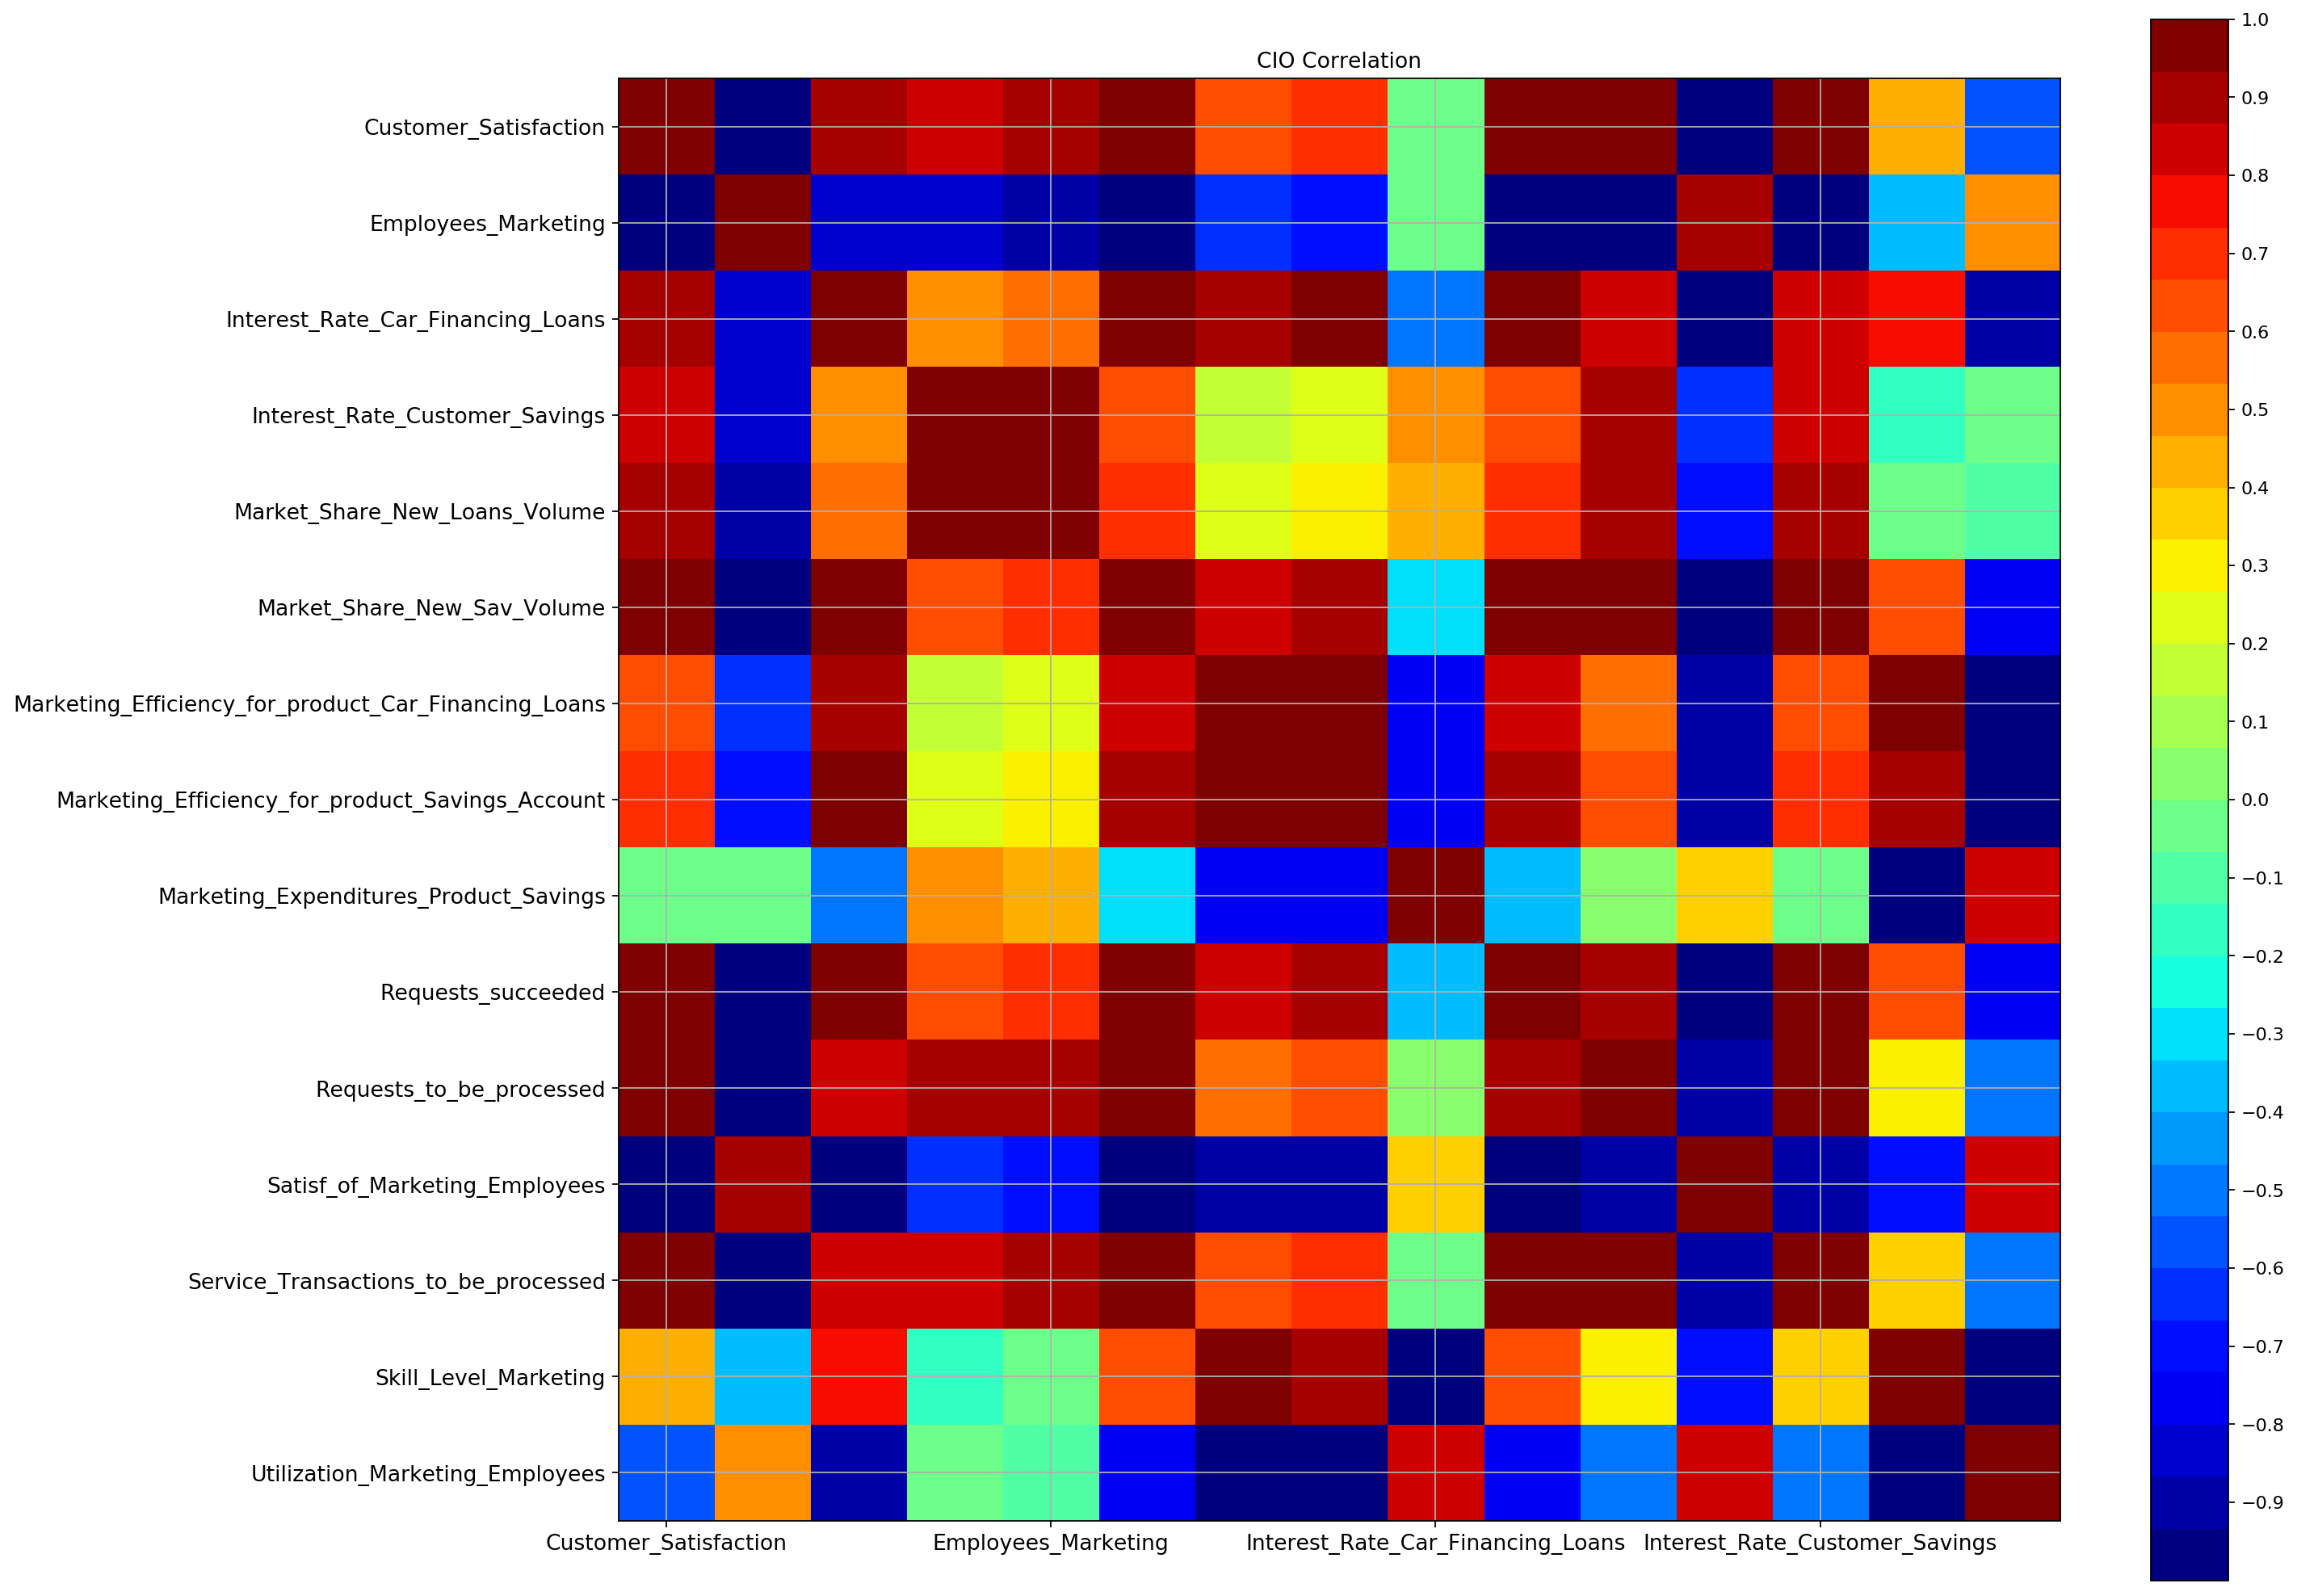

In [4]:
cio_game.correlation_matrix(cio_df.drop(["Marketing_Expenditures_Global","Marketing_Expenditures_Product_Loans"],axis=1))

## Hypo1: #Emp \* Utili \* MaxBudget = LoansExp \* LoansEffi + SavingsExp \* SavingsEffi
Each marketing employee can only administer a certain budget (Marketing Budget). We are trying to calculate the max marketing budget of an employee

In [31]:
max_budgets_hypo2=[]
max_budgets_hypo1=[] # * instead of /
for i in range(periods+1):
    max_budgets_hypo2.append((cio_game.Marketing_Expenditures_Product_Loans[i]/cio_game.Marketing_Efficiency_for_product_Car_Financing_Loans[i]+cio_game.Marketing_Expenditures_Product_Savings[i]/cio_game.Marketing_Efficiency_for_product_Savings_Account[i])/(cio_game.Employees_Marketing[i]*cio_game.Utilization_Marketing_Employees[i]))
    max_budgets_hypo1.append((cio_game.Marketing_Expenditures_Product_Loans[i]*cio_game.Marketing_Efficiency_for_product_Car_Financing_Loans[i]+cio_game.Marketing_Expenditures_Product_Savings[i]*cio_game.Marketing_Efficiency_for_product_Savings_Account[i])/(cio_game.Employees_Marketing[i]*cio_game.Utilization_Marketing_Employees[i]))
for budget in max_budgets_hypo2:
    print(budget)
print("ave.: ",sum(max_budgets_hypo2)/len(max_budgets_hypo2))
for budget in max_budgets_hypo1:
    print(budget)
print("ave.: ",sum(max_budgets_hypo1)/len(max_budgets_hypo1))

217210.26958962626
222477.9611492858
224444.6376101068
ave.:  221377.62278300629
111333.40812258552
102743.31372859285
136965.925532229
ave.:  117014.21579446913


In [ ]:
max_budgets_hypo3=[]
for i in range(periods+1):
    max_budgets_hypo3.append()

In [28]:
cio_df["Marketing_Efficiency_for_product_Car_Financing_Loans"].mean()

0.7372333333333333

In [32]:
1200000*0.75

900000.0

# Reports in previous semesters

In [37]:
file = 'CMO_Controlling-Tool.xlsx'
# Load spreadsheet
xl = pd.ExcelFile(file)

In [42]:
df=xl.parse('Marketing KPIs').drop(list(range(10,18)))

In [43]:
df

,Periode,Periode 0,Periode 1,Periode 2,Periode 3,Periode 4,Periode 5,Periode 6,Periode 7,Periode 8,Periode 9
0,Kundenzufriedenheit,8.329000e-01,8.487000e-01,8.950000e-01,9.249000e-01,9.550000e-01,9.500000e-01,9.536000e-01,9.500000e-01,9.700000e-01,9.536000e-01
1,Marktanteil (New Loans),4.570000e-02,1.462000e-01,2.806000e-01,3.518000e-01,3.485000e-01,3.384000e-01,3.815000e-01,4.390000e-01,4.403000e-01,4.472000e-01
2,Marktanteil (New Savings),1.940000e-02,9.320000e-02,2.001000e-01,5.760000e-01,5.242000e-01,5.639000e-01,5.231000e-01,4.991000e-01,4.811000e-01,7.731000e-01
3,Marketingeffizienz Autofinanzierung,7.295000e-01,6.938000e-01,9.036000e-01,9.810000e-01,9.885000e-01,9.812000e-01,9.878000e-01,9.917000e-01,9.917000e-01,9.866000e-01
4,Marketingeffizienz Sparanlagen,6.915000e-01,6.576000e-01,8.954000e-01,9.808000e-01,9.885000e-01,9.912000e-01,9.878000e-01,9.917000e-01,9.917000e-01,9.866000e-01
5,Fehlerrate der Mitarbeiter,9.900000e-03,1.000000e-02,9.800000e-03,1.030000e-02,9.900000e-03,9.900000e-03,9.800000e-03,9.800000e-03,9.900000e-03,1.000000e-02
6,Prozessqualität,9.999000e-01,9.999000e-01,9.999000e-01,9.999000e-01,9.999000e-01,9.999000e-01,9.999000e-01,9.999000e-01,9.999000e-01,9.999000e-01
7,Mitarbeiterzufriedenheit,7.960000e-01,8.450000e-01,7.298000e-01,5.498000e-01,6.878000e-01,7.387000e-01,7.021000e-01,6.884000e-01,5.788000e-01,3.101000e-01
8,Mitarbeiterauslastung,6.373000e-01,8.946000e-01,3.737000e-01,1.959200e+00,8.142000e-01,7.666000e-01,6.000000e-01,4.882000e-01,5.250000e-01,1.003700e+00
9,Qualifikationsniveau,8.400000e-01,8.389000e-01,9.475000e-01,9.745000e-01,9.781000e-01,9.798000e-01,9.765000e-01,9.814000e-01,9.813000e-01,9.755000e-01


In [44]:
df=df.set_index([list(df.iloc[:,0])]).iloc[:,1:].transpose().drop(['Prozessqualität'],axis=1)

In [45]:
df

,Kundenzufriedenheit,Marktanteil (New Loans),Marktanteil (New Savings),Marketingeffizienz Autofinanzierung,Marketingeffizienz Sparanlagen,Fehlerrate der Mitarbeiter,Mitarbeiterzufriedenheit,Mitarbeiterauslastung,Qualifikationsniveau,Global,Autofinanzierung,Sparanlagen,Zinssatz Autofinanzierung,Zinssatz Sparanlagen
Periode 0,0.8329,0.0457,0.0194,0.7295,0.6915,0.0099,0.7960,0.6373,0.8400,4500000.0,2220000.0,1200000.0,0.12,0.030
Periode 1,0.8487,0.1462,0.0932,0.6938,0.6576,0.0100,0.8450,0.8946,0.8389,4000000.0,3500000.0,3500000.0,0.13,0.032
Periode 2,0.8950,0.2806,0.2001,0.9036,0.8954,0.0098,0.7298,0.3737,0.9475,6000000.0,7000000.0,4500000.0,0.14,0.032
Periode 3,0.9249,0.3518,0.5760,0.9810,0.9808,0.0103,0.5498,1.9592,0.9745,10000000.0,15000000.0,15000000.0,0.15,0.025
Periode 4,0.9550,0.3485,0.5242,0.9885,0.9885,0.0099,0.6878,0.8142,0.9781,10000000.0,30000000.0,20000000.0,0.16,0.015
Periode 5,0.9500,0.3384,0.5639,0.9812,0.9912,0.0099,0.7387,0.7666,0.9798,10000000.0,40000000.0,20000000.0,0.17,0.013
Periode 6,0.9536,0.3815,0.5231,0.9878,0.9878,0.0098,0.7021,0.6000,0.9765,20000000.0,45000000.0,12000000.0,0.17,0.010
Periode 7,0.9500,0.4390,0.4991,0.9917,0.9917,0.0098,0.6884,0.4882,0.9814,25000000.0,40000000.0,5000000.0,0.17,0.010
Periode 8,0.9700,0.4403,0.4811,0.9917,0.9917,0.0099,0.5788,0.5250,0.9813,25000000.0,30000000.0,20000000.0,0.17,0.010
Periode 9,0.9536,0.4472,0.7731,0.9866,0.9866,0.0100,0.3101,1.0037,0.9755,30000000.0,30000000.0,10000000.0,0.17,0.010


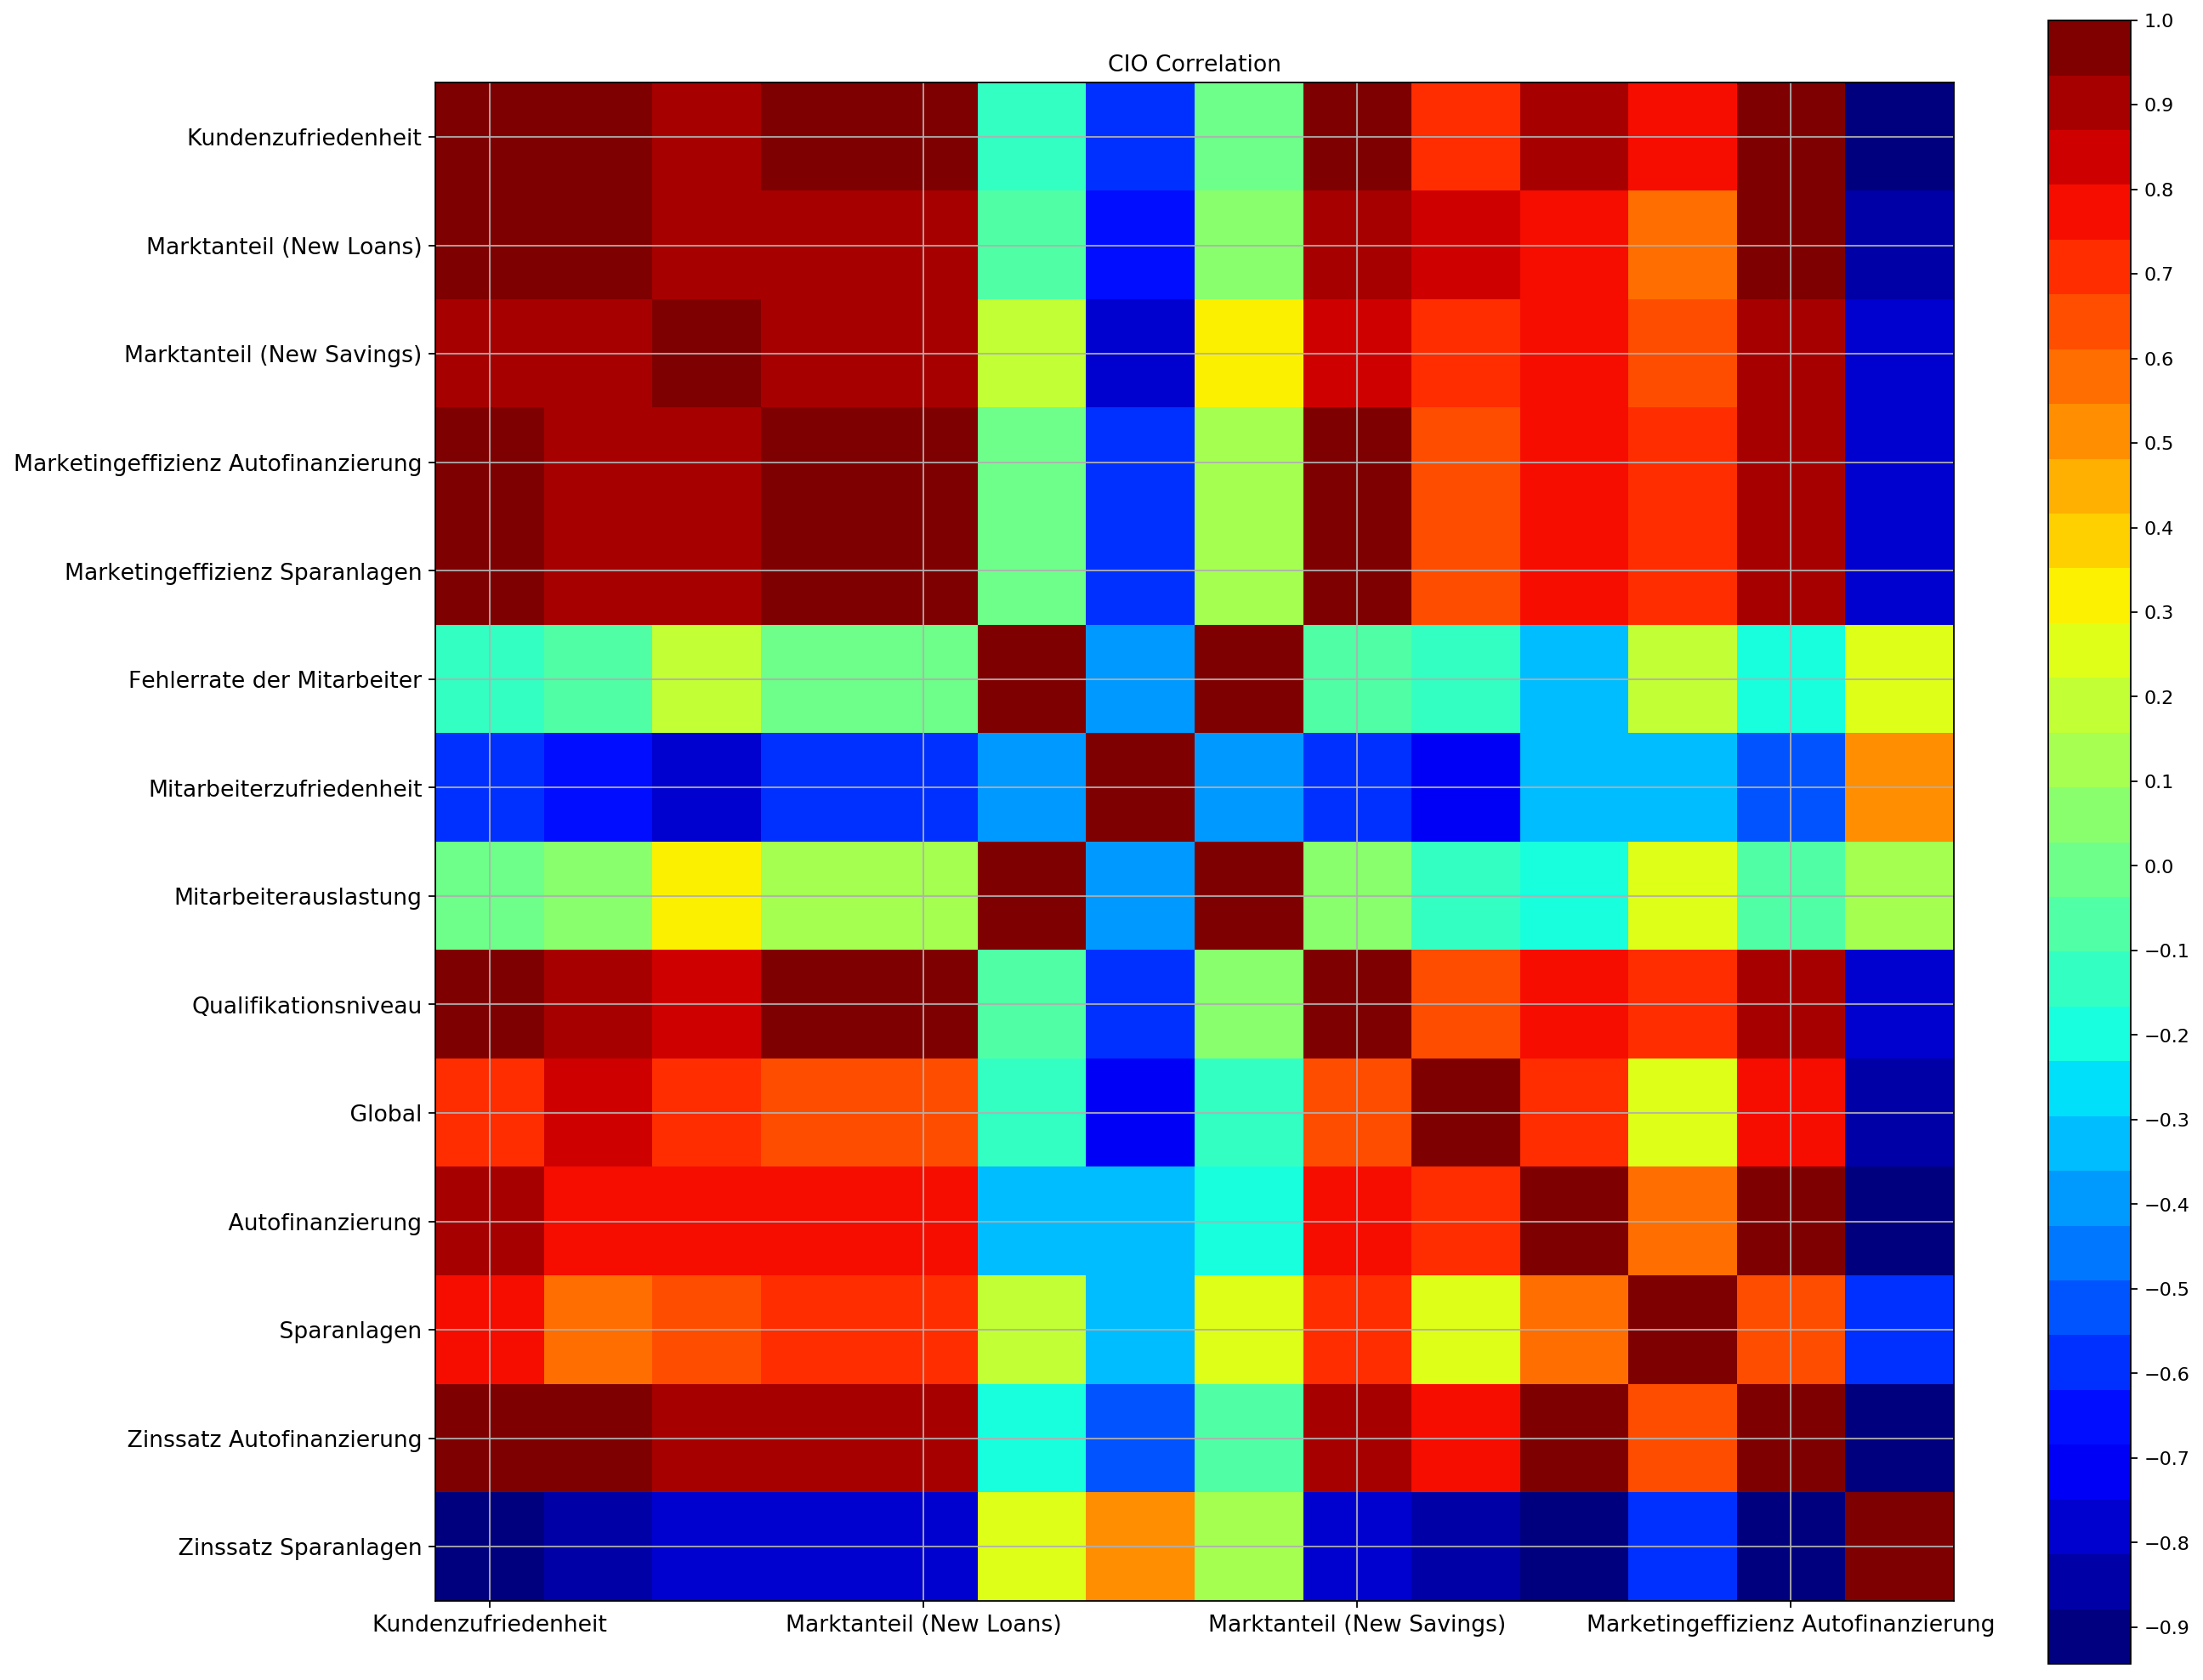

In [46]:
cio_game.correlation_matrix(df)

In [47]:
df_corr=df.corr()
df_corr

,Kundenzufriedenheit,Marktanteil (New Loans),Marktanteil (New Savings),Marketingeffizienz Autofinanzierung,Marketingeffizienz Sparanlagen,Fehlerrate der Mitarbeiter,Mitarbeiterzufriedenheit,Mitarbeiterauslastung,Qualifikationsniveau,Global,Autofinanzierung,Sparanlagen,Zinssatz Autofinanzierung,Zinssatz Sparanlagen
Kundenzufriedenheit,1.000000,0.953059,0.893135,0.956071,0.956529,-0.102862,-0.569148,0.000351,0.953092,0.732457,0.874343,0.753977,0.970386,-0.892797
Marktanteil (New Loans),0.953059,1.000000,0.889327,0.926462,0.925098,-0.037214,-0.672253,0.046599,0.932764,0.817058,0.786544,0.579053,0.937085,-0.825358
Marktanteil (New Savings),0.893135,0.889327,1.000000,0.885757,0.886656,0.208564,-0.778495,0.325243,0.869818,0.722734,0.767230,0.657920,0.886802,-0.811760
Marketingeffizienz Autofinanzierung,0.956071,0.926462,0.885757,1.000000,0.999576,-0.031880,-0.592065,0.094485,0.995164,0.649569,0.799205,0.692003,0.899298,-0.787340
Marketingeffizienz Sparanlagen,0.956529,0.925098,0.886656,0.999576,1.000000,-0.031991,-0.583897,0.094602,0.996581,0.639544,0.801884,0.699200,0.902026,-0.784688
Fehlerrate der Mitarbeiter,-0.102862,-0.037214,0.208564,-0.031880,-0.031991,1.000000,-0.368525,0.968971,-0.045155,-0.157154,-0.329905,0.187556,-0.176065,0.256340
Mitarbeiterzufriedenheit,-0.569148,-0.672253,-0.778495,-0.592065,-0.583897,-0.368525,1.000000,-0.375213,-0.565120,-0.730200,-0.308083,-0.313246,-0.537023,0.506455
Mitarbeiterauslastung,0.000351,0.046599,0.325243,0.094485,0.094602,0.968971,-0.375213,1.000000,0.076798,-0.127779,-0.179505,0.237816,-0.068315,0.157567
Qualifikationsniveau,0.953092,0.932764,0.869818,0.995164,0.996581,-0.045155,-0.565120,0.076798,1.000000,0.622929,0.784340,0.688933,0.896694,-0.758028
Global,0.732457,0.817058,0.722734,0.649569,0.639544,-0.157154,-0.730200,-0.127779,0.622929,1.000000,0.688390,0.241401,0.791033,-0.841751


In [50]:
df_corr.abs().sort_values(by=['     Global'],ascending=False)#.drop(["Marktanteil (New Savings)","Kundenzufriedenheit"])

,Kundenzufriedenheit,Marktanteil (New Loans),Marktanteil (New Savings),Marketingeffizienz Autofinanzierung,Marketingeffizienz Sparanlagen,Fehlerrate der Mitarbeiter,Mitarbeiterzufriedenheit,Mitarbeiterauslastung,Qualifikationsniveau,Global,Autofinanzierung,Sparanlagen,Zinssatz Autofinanzierung,Zinssatz Sparanlagen
Global,0.732457,0.817058,0.722734,0.649569,0.639544,0.157154,0.730200,0.127779,0.622929,1.000000,0.688390,0.241401,0.791033,0.841751
Zinssatz Sparanlagen,0.892797,0.825358,0.811760,0.787340,0.784688,0.256340,0.506455,0.157567,0.758028,0.841751,0.943039,0.584875,0.942547,1.000000
Marktanteil (New Loans),0.953059,1.000000,0.889327,0.926462,0.925098,0.037214,0.672253,0.046599,0.932764,0.817058,0.786544,0.579053,0.937085,0.825358
Zinssatz Autofinanzierung,0.970386,0.937085,0.886802,0.899298,0.902026,0.176065,0.537023,0.068315,0.896694,0.791033,0.938521,0.659155,1.000000,0.942547
Kundenzufriedenheit,1.000000,0.953059,0.893135,0.956071,0.956529,0.102862,0.569148,0.000351,0.953092,0.732457,0.874343,0.753977,0.970386,0.892797
Mitarbeiterzufriedenheit,0.569148,0.672253,0.778495,0.592065,0.583897,0.368525,1.000000,0.375213,0.565120,0.730200,0.308083,0.313246,0.537023,0.506455
Marktanteil (New Savings),0.893135,0.889327,1.000000,0.885757,0.886656,0.208564,0.778495,0.325243,0.869818,0.722734,0.767230,0.657920,0.886802,0.811760
Autofinanzierung,0.874343,0.786544,0.767230,0.799205,0.801884,0.329905,0.308083,0.179505,0.784340,0.688390,1.000000,0.572923,0.938521,0.943039
Marketingeffizienz Autofinanzierung,0.956071,0.926462,0.885757,1.000000,0.999576,0.031880,0.592065,0.094485,0.995164,0.649569,0.799205,0.692003,0.899298,0.787340
Marketingeffizienz Sparanlagen,0.956529,0.925098,0.886656,0.999576,1.000000,0.031991,0.583897,0.094602,0.996581,0.639544,0.801884,0.699200,0.902026,0.784688
